# Setup

In [6]:
import figure_utilities
import constants
from stats_utilities import select_controls, test_balance
import matplotlib.pyplot as plt
from panel_utilities import get_value_variable_names, prepare_df_for_DiD
plt.rcParams['savefig.dpi'] = 300
import statsmodels.formula.api as smf
import os
from differences import ATTgt
import pandas as pd

In [7]:
# Store paths.
INPUT_DATA_PANEL = "../data/03_cleaned/crime_analysis_monthly.csv"
OUTPUT_TABLES = "../output/final_paper/tables"
OUTPUT_FIGURES = "../output/final_paper/figures"

# Main Results

In [8]:
# Read fresh copy of unrestricted dataset into memory.
df = pd.read_csv(INPUT_DATA_PANEL)
treatment_date_variable = 'latest_docket_month'  # Store treatment date variable.


In [9]:
# Generate value variables list and dictionaries mapping between months and integers.
analysis = f"group_0_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m"
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [10]:
# Re-Balance on Controls
balance_table, pre_treatment_covariates = test_balance(df, analysis, OUTPUT_TABLES)
print(f"Number of covariates: {len(pre_treatment_covariates)}")
balance_table

Number of covariates: 10


\
                                                  Cases Won by Plaintiff   
Panel A Total Incidents, 2017                                 338.181152   
        $\Delta$ Incidents, 2017-2019                         -50.048168   
        $\Delta$ Incidents, 2 Years Pre-Treatment              -4.663874   
Panel B Bachelor's degree, 2010                                 0.316407   
        Job density, 2013                                   16161.032515   
        Median household income, 2016                       47553.063874   
        Poverty rate, 2010                                      0.279638   
        Population density, 2010                            23320.185868   
        Share white, 2010                                       0.319421   
Panel C Filing for cause                                        0.132984   
        Defendant is entity                                     0.019895   
        Filing for nonpayment                                   0.716230   

                                                  Difference in Cases Won by Defendant  \
                                                                            Unweighted   
Panel A Total Incidents, 2017                                               -10.547731   
        $\Delta$ Incidents, 2017-2019                                       -15.579503   
        $\Delta$ Incidents, 2 Years Pre-Treatment                            -1.688398   
Panel B Bachelor's degree, 2010                                               0.002512   
        Job density, 2013                                                 -1272.661768   
        Median household income, 2016                                      2997.870414   
        Poverty rate, 2010                                                   -0.021030   
        Population density, 2010                                           -297.766413   
        Share white, 2010                                                     0.012446   
Panel C Filing for cause                                                      0.043066   
        Defendant is entity                                                  -0.008715   
        Filing for nonpayment                                                -0.106658   

                                                                              \
                                                       \emph{p}     Weighted   
Panel A Total Incidents, 2017                      4.017521e-01   -11.456601   
        $\Delta$ Incidents, 2017-2019              6.851633e-03     3.094776   
        $\Delta$ Incidents, 2 Years Pre-Treatment  1.959620e-01     0.340861   
Panel B Bachelor's degree, 2010                    8.133641e-01    -0.010714   
        Job density, 2013                          5.501121e-01 -1326.158638   
        Median household income, 2016              1.427126e-02 -1834.887114   
        Poverty rate, 2010                         4.904136e-03    -0.006457   
        Population density, 2010                   6.737331e-01  -652.164003   
        Share white, 2010                          3.450948e-01    -0.010175   
Panel C Filing for cause                           5.801068e-03    -0.001314   
        Defendant is entity                        2.432211e-01    -0.012205   
        Filing for nonpayment                      3.013004e-07    -0.023745   

                                                             
                                                   \emph{p}  
Panel A Total Incidents, 2017                      0.364424  
        $\Delta$ Incidents, 2017-2019              0.555316  
        $\Delta$ Incidents, 2 Years Pre-Treatment  0.770129  
Panel B Bachelor's degree, 2010                    0.314596  
        Job density, 2013                          0.529086  
        Median household income, 2016              0.147859  
        Poverty rate, 2010                         0.389956  
        Population density, 2010                   0.355042  
       

## Unconditional DiD Using Neighborhood, Latest Docket Date Dummies

In [11]:
df = pd.read_csv(INPUT_DATA_PANEL)
df = df.loc[~df[treatment_date_variable].isin(['2019-04', '2019-05']), :]
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)
# Run DiD conditional on covariates.
att_gt_all_crimes = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
formula = f'{analysis}'
result = att_gt_all_crimes.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)

# Plot D.R. ATT(t-g)s on a long horizon.
fig, ax = plt.subplots(layout='constrained')
figure_utilities.aggregate_by_event_time_and_plot(att_gt_all_crimes,
                                                  start_period=constants.Analysis.MINIMUM_PRE_PERIOD,
                                                  end_period=constants.Analysis.MAXIMUM_POST_PERIOD,
                                                  title="", ax=ax)

figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_unconditional_all_crimes.png"))

Computing ATTgt [workers=12]  100%|████████████████████| 980/980 [00:02<00:00, 351.73it/s]


## Doubly Robust DiD Conditional on Covariates

In [12]:
df = pd.read_csv(INPUT_DATA_PANEL)
df = df.loc[~df[treatment_date_variable].isin(['2019-04', '2019-05']), :]
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)
# Run DiD conditional on covariates.
att_gt_all_crimes = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
att_gt_all_crimes.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)
# Plot D.R. ATT(t-g)s on a long horizon.
fig, ax = plt.subplots(layout='constrained')

figure_utilities.aggregate_by_event_time_and_plot(att_gt_all_crimes,
                                                  start_period=constants.Analysis.MINIMUM_PRE_PERIOD,
                                                  end_period=constants.Analysis.MAXIMUM_POST_PERIOD,
                                                  title="", ax=ax)

figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_all_crimes.png"))

Computing ATTgt [workers=12]  100%|████████████████████| 980/980 [00:02<00:00, 357.63it/s]


## Heterogeneous Treatment Effects

In [13]:
point_estimates = []
ci_uppers = []
ci_lowers = []
pretrend_p_values = []
for variable in ['popdensity2010', 'share_white2010', 'poor_share2010']:
    # Read fresh copy of unrestricted dataset into memory.
    df = pd.read_csv(INPUT_DATA_PANEL)

    # Generate indicator variable for above median value of current characteristic
    median = df[variable].median()
    above_median_indicator_name = f'above_median_{variable}'
    df.loc[:, above_median_indicator_name] = 0
    df.loc[df[variable] > median, above_median_indicator_name] = 1

    # Prepare DataFrame for DiD
    pre_treatment_covariates_minus_current_var = pre_treatment_covariates.copy()
    pre_treatment_covariates_minus_current_var.remove(variable)
    df = prepare_df_for_DiD(df=df,
                            analysis=analysis,
                            treatment_date_variable=treatment_date_variable,
                            pre_treatment_covariates=pre_treatment_covariates_minus_current_var + [above_median_indicator_name],
                            value_vars=weekly_value_vars_crime,
                            period_to_int_dictionary=month_to_int_dictionary)

    # Run DiD
    att_gt_by_sample = ATTgt(data=df,
                             cohort_name=treatment_date_variable,
                             base_period='universal')
    att_gt_by_sample.fit(formula=f'{analysis} ~ relative_pre_treatment_change_in_{analysis}',
                         control_group='never_treated',
                         split_sample_by=f'above_median_{variable}',
                         n_jobs=-1,
                         progress_bar=True)

    att_gt_by_sample = att_gt_by_sample.aggregate('event', overall=True)

    # Collect point estimates, confidence interval bounds
    below_median_point_estimate = att_gt_by_sample.loc[f'above_median_{variable} = 0', ("EventAggregationOverall", slice(None), "ATT")]
    point_estimates.append(below_median_point_estimate)
    above_median_point_estimate = att_gt_by_sample.loc[f'above_median_{variable} = 1', ("EventAggregationOverall", slice(None), "ATT")]
    point_estimates.append(above_median_point_estimate)

    below_median_ci_lower = att_gt_by_sample.loc[f'above_median_{variable} = 0', ("EventAggregationOverall", "pointwise conf. band", "lower")]
    ci_lowers.append(below_median_ci_lower)
    above_median_ci_lower = att_gt_by_sample.loc[f'above_median_{variable} = 1', ("EventAggregationOverall", "pointwise conf. band", "lower")]
    ci_lowers.append(above_median_ci_lower)

    below_median_ci_upper = att_gt_by_sample.loc[f'above_median_{variable} = 0', ("EventAggregationOverall", "pointwise conf. band", "upper")]
    ci_uppers.append(below_median_ci_upper)
    above_median_ci_upper = att_gt_by_sample.loc[f'above_median_{variable} = 1', ("EventAggregationOverall", "pointwise conf. band", "upper")]
    ci_uppers.append(above_median_ci_upper)



fig, ax = plt.subplots()
figure_utilities.plot_labeled_vline(ax, x=0, text="", color='black', linestyle='-')
for i, (ci_lower, ci_upper) in enumerate(zip(ci_lowers, ci_uppers)):
    ax.hlines(y=i, xmin=ci_lower, xmax=ci_upper, color='black')
ax.scatter(point_estimates, range(len(point_estimates)), color='black', s=7)
ax.set_yticks(ticks=range(len(point_estimates)),
              labels=["Below median population density, 2010",
                      "Above median population density, 2010",
                      "Below median share white, 2010",
                      "Above median share white, 2010",
                      "Below median share below poverty line, 2010",
                      "Above median share below poverty line, 2010"])
ax.set_ylabel("Sample Restriction")
ax.set_xlabel("Average Post-Treatment ATT")

figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "heterogenous_effects.png"))

Computing ATTgt for above_median_popdensity2010 = 0 [workers=12]100%|████████████████████| 1176/1176 [00:03<00:00, 386.62it/s] 
Computing ATTgt for above_median_popdensity2010 = 1 [workers=12]100%|████████████████████| 1176/1176 [00:01<00:00, 1039.48it/s]
Computing ATTgt for above_median_share_white2010 = 0 [workers=12]100%|████████████████████| 1176/1176 [00:02<00:00, 461.96it/s] 
Computing ATTgt for above_median_share_white2010 = 1 [workers=12]100%|████████████████████| 1176/1176 [00:01<00:00, 1039.46it/s]
Computing ATTgt for above_median_poor_share2010 = 0 [workers=12]100%|████████████████████| 1176/1176 [00:02<00:00, 520.68it/s] 
Computing ATTgt for above_median_poor_share2010 = 1 [workers=12]100%|████████████████████| 1176/1176 [00:01<00:00, 1090.67it/s]


## Calculating Treatment Effects Using Subset of Crimes as Outcome

In [14]:
df = pd.read_csv(INPUT_DATA_PANEL)
# Generate value variables list and dictionaries mapping between months and integers.
analysis = f"group_1_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m"
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)
df = df.loc[~df[treatment_date_variable].isin(['2019-04', '2019-05']), :]
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

# Run DiD conditional on covariates.
att_gt_group_1_crimes = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt_group_1_crimes.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)

# Plot D.R. ATT(t-g)s for placebo crimes next to D.R. ATT(t-g)s for all crimes.
fig, (ax1, ax2) = plt.subplots(1, 2, layout='constrained', sharey=True)

figure_utilities.aggregate_by_event_time_and_plot(att_gt_all_crimes, start_period=-5,
                                                  end_period=36,
                                                  title="All Crime Incidents as Outcome", ax=ax1)
figure_utilities.aggregate_by_event_time_and_plot(att_gt_group_1_crimes, start_period=-5,
                                                  end_period=36,
                                                  title="Subset of Crime Incidents as Outcome", ax=ax2)

figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_group_1_crimes.png"))

Computing ATTgt [workers=12]  100%|████████████████████| 980/980 [00:02<00:00, 332.29it/s]


## Alternative Radii

Computing ATTgt [workers=12]  100%|████████████████████| 980/980 [00:02<00:00, 342.82it/s]


ValueError: list.remove(x): x not in list

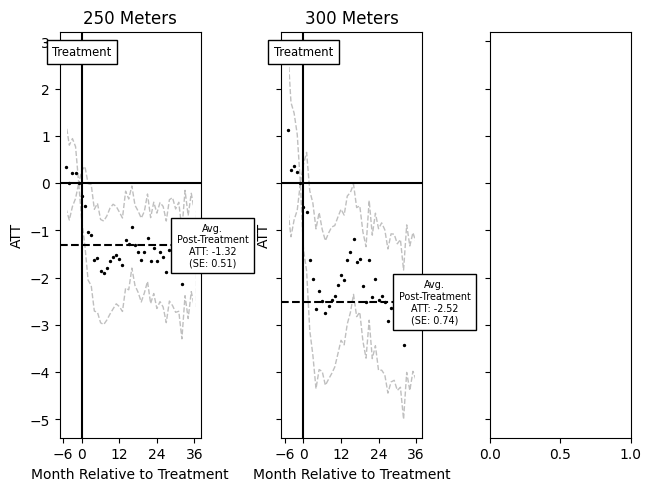

In [15]:
fig, axes = plt.subplots(1, 3, layout='constrained', sharey=True)
radii = [constants.Analysis.MAIN_RESULTS_RADIUS, constants.Analysis.MAIN_RESULTS_RADIUS + 50, constants.Analysis.MAIN_RESULTS_RADIUS + 100]
atts = []
att_labels = ["$<$250m from property", "$<$300m from property", "$<$350m from property", "250-300m from property", "250-350m from property", "250-400m from property"]
for ax, radius in zip(axes, radii):
    if radius != constants.Analysis.MAIN_RESULTS_RADIUS:
        df = pd.read_csv(INPUT_DATA_PANEL)
        df = df.loc[~df[treatment_date_variable].isin(['2019-04', '2019-05']), :]

        analysis = f"group_0_crimes_{radius}m"
        weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)
        _, pre_treatment_covariates = test_balance(df, analysis)


        df = prepare_df_for_DiD(df=df,
                                analysis=analysis,
                                treatment_date_variable=treatment_date_variable,
                                pre_treatment_covariates=pre_treatment_covariates,
                                value_vars=weekly_value_vars_crime,
                                period_to_int_dictionary=month_to_int_dictionary)
        # Run DiD conditional on covariates.
        current_att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
        formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
        current_att_gt.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)
        figure_utilities.aggregate_by_event_time_and_plot(current_att_gt,
                                                          start_period=constants.Analysis.MINIMUM_PRE_PERIOD,
                                                          end_period=constants.Analysis.MAXIMUM_POST_PERIOD,
                                                          title=f"{radius} Meters", ax=ax)
        atts.append(current_att_gt.aggregate('event', overall=True))
    else:
        figure_utilities.aggregate_by_event_time_and_plot(att_gt_all_crimes,
                                                          start_period=constants.Analysis.MINIMUM_PRE_PERIOD,
                                                          end_period=constants.Analysis.MAXIMUM_POST_PERIOD,
                                                          title=f"{radius} Meters", ax=ax)
        atts.append(att_gt_all_crimes.aggregate('event', overall=True)['EventAggregationOverall'].loc[:, slice('', 'ATT')].iloc[0])

figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_alternative_radii.png"))

In [ ]:

for robustness_radius in constants.Analysis.ROBUSTNESS_RADII:
    df = pd.read_csv(INPUT_DATA_PANEL)
    df = df.loc[~df[treatment_date_variable].isin(['2019-04', '2019-05']), :]
    analysis = f"group_0_crimes_{robustness_radius}m"
    weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)
    _, pre_treatment_covariates = test_balance(df, analysis)

    df = prepare_df_for_DiD(df=df,
                            analysis=analysis,
                            treatment_date_variable=treatment_date_variable,
                            pre_treatment_covariates=pre_treatment_covariates,
                            value_vars=weekly_value_vars_crime,
                            period_to_int_dictionary=month_to_int_dictionary)

    # Run DiD conditional on covariates.
    att_gt_all_crimes_donut = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
    formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
    att_gt_all_crimes_donut.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)


    atts.append(att_gt_all_crimes_donut.aggregate('event', overall=True)['EventAggregationOverall'].loc[:, slice('', 'ATT')].iloc[0])


In [ ]:
print(atts['EventAggregationOverall'].loc[:, slice('', 'ATT')].iloc[0])
